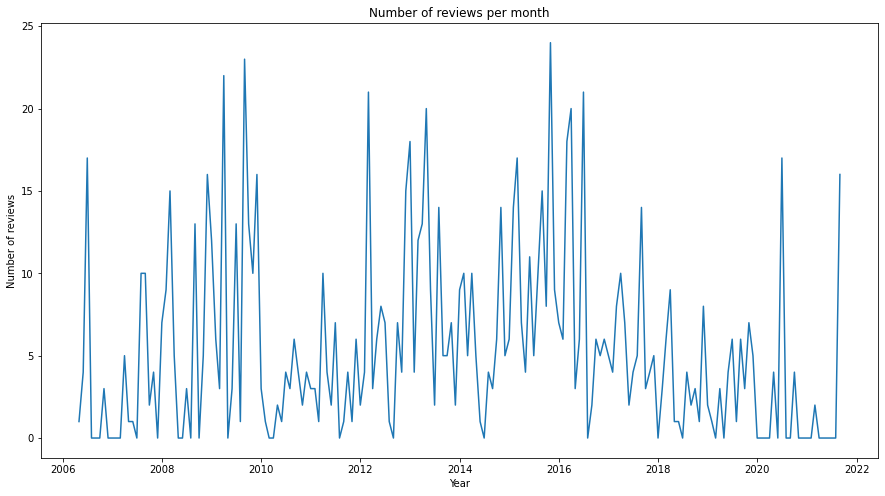

In [100]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (15, 8)


df = pd.read_csv("datas/data Kiel's restaurants 17-11-2021 .csv")

df["Date"] = pd.to_datetime(df["Date"])
df1 = df.set_index("Date")
plt.plot(df1["Comment"].resample("M").count())
plt.xlabel("Year")
plt.ylabel("Number of reviews")
plt.title("Number of reviews per month")
plt.show()

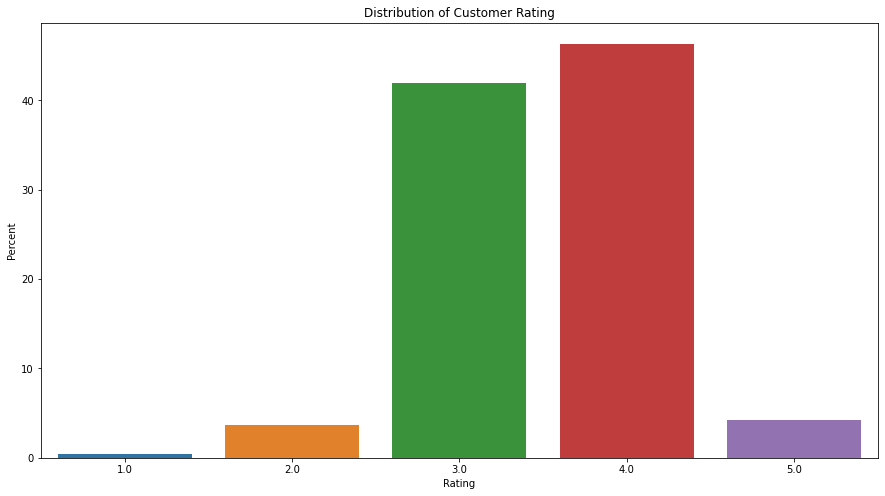

In [62]:
import seaborn as sns

df = pd.read_csv("datas/data Kiel's restaurants 17-11-2021 .csv")


ax = sns.barplot(
    data=df, x="Rating", y="Rating", estimator=lambda x: len(x) / len(df) * 100
)

ax.set(ylabel="Percent")
plt.title("Distribution of Customer Rating")
plt.show()

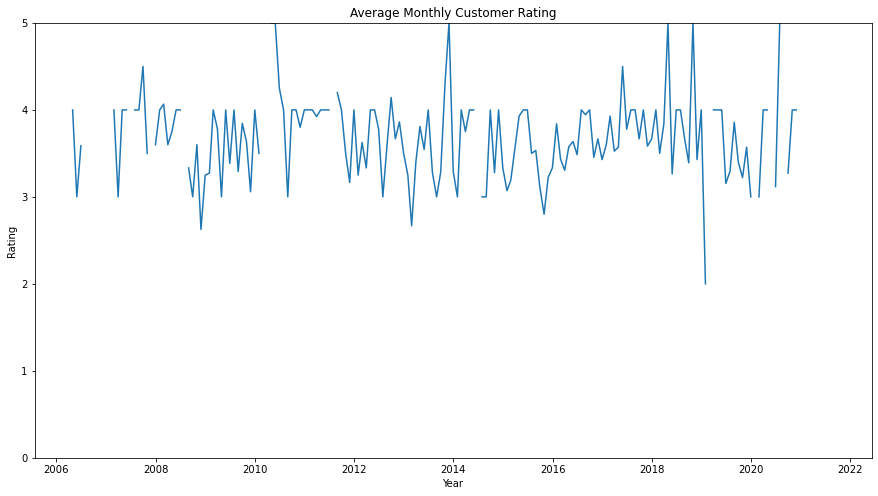

In [63]:
plt.plot(df1["Rating"].resample("M").mean())
plt.xlabel("Year")
plt.ylabel("Rating")
plt.title("Average Monthly Customer Rating")
plt.ylim(0, 5)
plt.show()

In [64]:
from nltk.corpus import stopwords

my_stop_words = set(stopwords.words("german"))

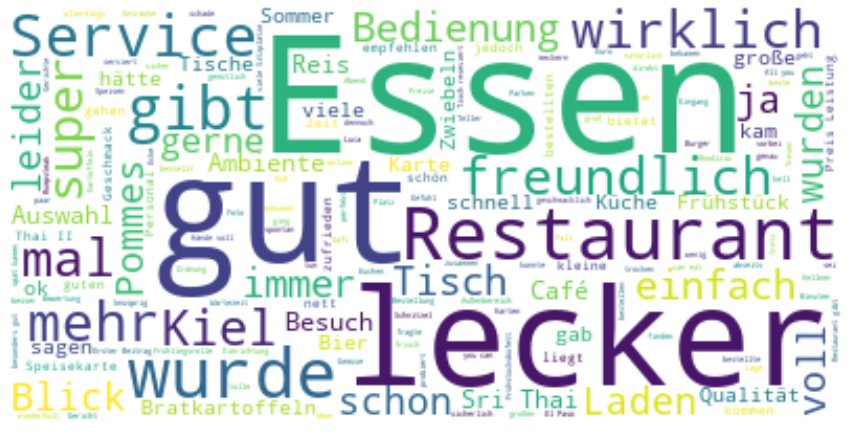

In [102]:
from wordcloud import WordCloud  # concatenate all the reviews into one single string

df["Comment_concatenate"] = df["Comment"] + df["Names_pictures"]
df = df[df["Comment_concatenate"].notna()]

full_text = " ".join(df["Comment_concatenate"].astype("str"))
cloud_no_stopword = WordCloud(
    background_color="white", stopwords=my_stop_words
).generate(full_text)
plt.imshow(cloud_no_stopword, interpolation="bilinear")
plt.axis("off")
plt.show()

<AxesSubplot:xlabel='Frequency', ylabel='Word'>

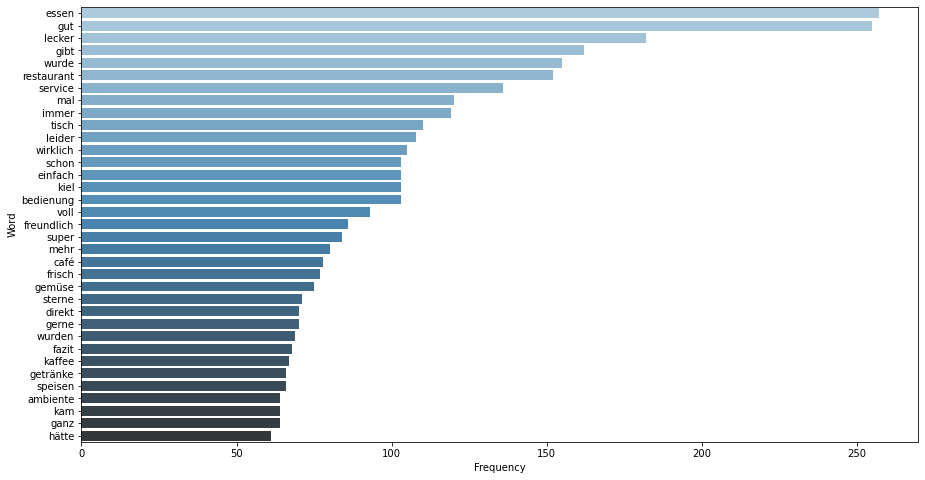

In [66]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize

lower_full_text = full_text.lower()
word_tokens = word_tokenize(lower_full_text)
tokens = list()
for word in word_tokens:
    if word.isalpha() and word not in my_stop_words:
        tokens.append(word)

token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(35), columns=["Word", "Frequency"])

sns.barplot(x="Frequency", y="Word", data=dist, palette="Blues_d")

<AxesSubplot:xlabel='frequency', ylabel='bigram'>

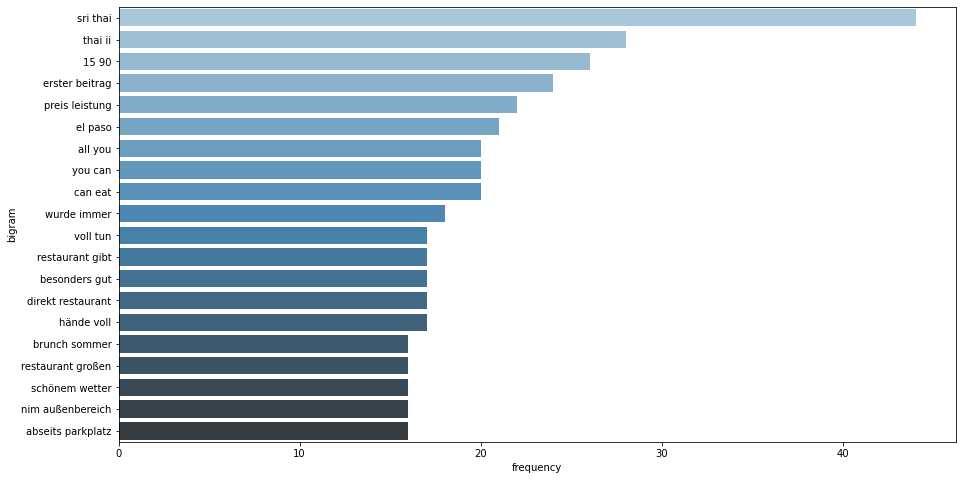

In [70]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words=my_stop_words, ngram_range=(2, 2))
bigrams = vect.fit_transform(df["Comment_concatenate"])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ["bigram", "frequency"]
bigram_frequency = bigram_frequency.sort_values(by="frequency", ascending=False).head(
    20
)

sns.barplot(x="frequency", y="bigram", data=bigram_frequency, palette="Blues_d")

In [76]:
import re

from nltk.tokenize import sent_tokenize

df_good = df[df["Rating"] > 3]
good_reviews = " ".join(df_good.Comment_concatenate)
# split the long string into sentences
sentences_good = sent_tokenize(good_reviews)
good_token_clean = list()
# get tokens for each sentence
for sentence in sentences_good:
    eng_word = re.findall(r"[A-Za-z\-]+", sentence)
    good_token_clean.append(
        [i.lower() for i in eng_word if i.lower() not in my_stop_words]
    )

In [87]:
from gensim.models import Word2Vec

model_ted = Word2Vec(
    sentences=good_token_clean, window=10, min_count=1, workers=4, sg=0
)
model_ted.predict_output_word(["service"], topn=10)

[('perfekter', 0.0025975022),
 ('gab', 0.0025975015),
 ('pizzen', 0.0025974968),
 ('aufw', 0.0025974887),
 ('gern', 0.0025974829),
 ('super', 0.002597478),
 ('chips', 0.002597477),
 ('rt', 0.002597476),
 ('erkl', 0.0025974703),
 ('platte', 0.0025974698)]

C:\Users\test\AppData\Local\Temp/ipykernel_19408/3463541062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_scores['sentiment'] = sentiment_scores['Comment_concatenate'].apply(sid.polarity_scores)
C:\Users\test\AppData\Local\Temp/ipykernel_19408/3463541062.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_scores['sentiment'] = sentiment_scores['sentiment'].apply(lambda x: x['compound'])


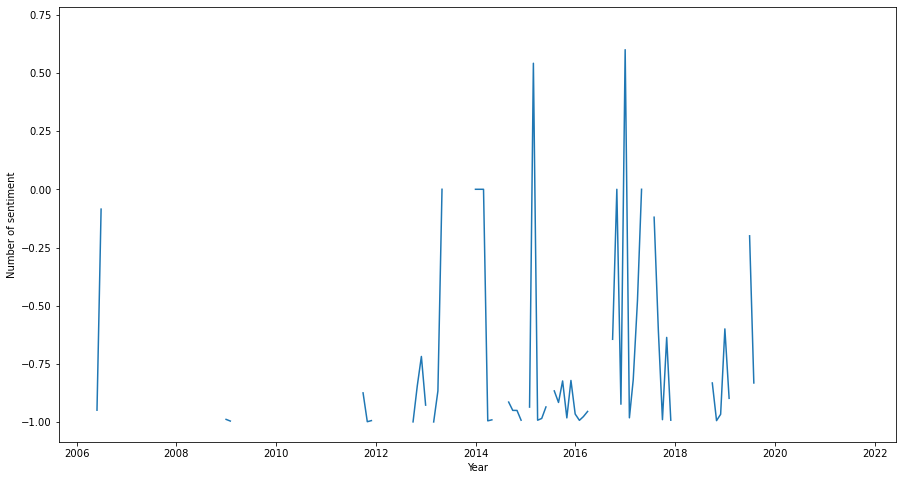

In [112]:
# Load SentimentIntensityAnalyzer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# nltk.download('vader_lexicon')

# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
# Generate sentiment scores
sentiment_scores = df[["Comment_concatenate", "Date"]]
sentiment_scores["sentiment"] = sentiment_scores["Comment_concatenate"].apply(
    sid.polarity_scores
)
sentiment_scores["sentiment"] = sentiment_scores["sentiment"].apply(
    lambda x: x["compound"]
)
sentiment_scores = sentiment_scores.set_index("Date")
plt.plot(sentiment_scores["sentiment"].resample("M").mean())
plt.xlabel("Year")
plt.ylabel("Number of sentiment")
plt.show()

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# vectorization
vect = CountVectorizer(max_features=300, stop_words=my_stop_words)
vect.fit(df.Comment_concatenate)
df["label"] = np.where(df["Rating"] > 3, 1, 0)
X = vect.transform(df.Comment_concatenate)
X_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
# Define the vector of targets and matrix of features
y = df.label
X = X_df
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

NameError: name 'my_stop_words' is not defined

In [2]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(X_train, y_train)
y_pred_lg = log_reg.predict(X_test)
# find the most informative words
log_odds = log_reg.coef_[0]
coeff = pd.DataFrame(log_odds, X.columns, columns=["coef"]).sort_values(
    by="coef", ascending=False
)

NameError: name 'X_train' is not defined

In [1]:
coeff.sort_value

NameError: name 'coeff' is not defined